In [2]:
import dill as pickle
import os
from pprint import pprint as pp
import json
import pandas as pd
from pandas.api.types import CategoricalDtype
from copy import deepcopy
from tqdm.notebook import tqdm_notebook as progress_bar
from pathlib import Path
import numpy as np
from datetime import datetime, timedelta
from typing import Union

In [3]:
main_path = Path('../bt_data_runs/aggregated_archive_df.pkl').resolve()
main_df = pd.read_pickle(main_path)
# new_path = Path('../bt_data_runs/cleaned_archive_df.pkl').resolve()
# updated_df.to_pickle(new_path)
# updated_df = pd.read_pickle(new_path)


In [4]:
main_df.tail()

buy_date  sell_date  buy_price  sale_price currency_id  \
14965939 2021-10-22 1900-01-01    69.8046        -1.0         СС7   
14965940 2021-10-22 1900-01-01    69.8046        -1.0         СС7   
14965941 2021-10-22 1900-01-01    69.8046        -1.0         СС7   
14965942 2021-10-22 1900-01-01    69.8046        -1.0         СС7   
14965943 2021-10-22 1900-01-01    69.8046        -1.0         СС7   

                       run_name  status  sell_price_multiple  \
14965939  СС7(30,12,10.0,False)  opened                   12   
14965940  СС7(30,14,10.0,False)  opened                   14   
14965941  СС7(30,16,10.0,False)  opened                   16   
14965942  СС7(30,18,10.0,False)  opened                   18   
14965943  СС7(30,20,10.0,False)  opened                   20   

          buy_volume_multiple  volume_avg_duration  transparent  \
14965939                   10                   30        False   
14965940                   10                   30        False   
14965941                   10                   30        False   
14965942                   10                   30        False   
14965943                   10                   30        False   

          buy_avg_volume  
14965939           4.639  
14965940           4.639  
14965941           4.639  
14965942           4.639  
14965943           4.639

In [40]:
main_df.dtypes

buy_date               datetime64[ns]
sell_date              datetime64[ns]
buy_price                     float64
sale_price                    float64
currency_id                    object
run_name                       object
status                       category
sell_price_multiple             int16
buy_volume_multiple             int16
volume_avg_duration             int16
transparent                      bool
buy_avg_volume                float32
dtype: object

### Functions:
<ol>
<li>A function to update the datatypes of the different columns.-done</li>
<li>A function to calculate profit of the trade for a given row.-done</li>
<li>A function to calculate present price of the currency if the position was not closed.-done</li>
<li>A function to calculate duration of trade in days.-done</li>
<li>A function to calculate ROI.-done</li>
<li>A function to calculate ROI as % for 30 days.-done</li>
<li>A function to return the price of a currency X days after initiating buy. Error handling for not enough data.-done</li>
</ol>

In [5]:
def apply_functions(raw_df: pd.DataFrame, duration_max: int = 0) -> pd.DataFrame:
    df = deepcopy(raw_df)
    # data now pre-typed
    # df = type_raw_dataframe(raw_df)
    MaxDate = max_date(df) - timedelta(days=duration_max)
    # drop rows where the duration max would not allow the trade time to conclude naturally.
    df.drop(df[df['buy_date'] >= MaxDate].index, inplace=True)
    df[['sale_price', 'sell_date', 'status']] = df.apply(fill_in_open_positions, axis=1, dated=duration_max, result_type="expand")
    df['duration'] = df.apply(calculate_duration, axis=1, max_date=MaxDate).astype('int32')
    df['profit'] = df.apply(calculate_profit, axis=1)
    # get rid of 0 priced positions
    df = df[df['buy_price'] > 0]
    df['ROI'] = df.apply(calculate_ROI, axis=1).astype('float64')
    df['monthly_ROI'] = df.apply(calculate_monthly_ROI, axis=1).astype('float64')
    
    return df

def type_raw_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    cat_status = CategoricalDtype(
        categories=['closed', 'opened'], 
        ordered=True,
        )
    return_df = df.astype(
        {
            'buy_date': 'datetime64',
            'sell_date': 'datetime64',
            'buy_price': 'float64',
            'sale_price': 'float64',
            'currency_id': 'str',
            'run_name': str,
            'status': cat_status,
            'sell_price_multiple': 'int16',
            'buy_volume_multiple': 'int16',
            'volume_avg_duration': 'int16',
            'transparent': bool,

        }, copy=True
    )
    # return_df['buy_date'] = pd.to_datetime(return_df['buy_date'], infer_datetime_format=True)
    # return_df['sell_date'] = pd.to_datetime(return_df['sell_date'], infer_datetime_format=True)
    return return_df

def calculate_profit(row: pd.DataFrame) -> float:
    if row['sale_price'] != -1:
        return row['sale_price'] - row['buy_price']
    else:
        raise ValueError('Sale price not updated, aborting...')

def fill_in_open_positions(row: pd.DataFrame, dated:int=0) -> Union[float, datetime, str]:
    """
    If dated = 0, fills in the sale price of open positions with pricing from the final closing day or the closing price, if closed.
    If dated > 0, fills in the sale price of open positions with pricing from the opening day plus X days.
    If there are not enough days, i.e. the position was opened less than X days ago, drop the trade from analysis (taken care of in earlier step). This is the most fair way to treat "too young" of trades, by not allowing closed trades to be included in the analysis and bias the profit too highly.
    returns: sale price, sell date, status
    """

    if row['transparent'] == True:
        close = 'transparent_close'
        volume = 'transparent_volume'
    else:
        close = 'close'
        volume = 'volume'
    max_close_date = row['buy_date'] + timedelta(days=dated)
    
    if row['status'] == 'closed' and row['sell_date'] <= max_close_date:
        return row['sale_price'], row['sell_date'], 'closed'
    currency = row['currency_id']
    candle_location = Path(f'../downloaded_data/nomics/candles/{currency}.pkl').resolve()
    currency_df = pd.read_pickle(candle_location)
    # troubleshooting determined in 1/12/2022
    # if open, and if volume in final week is < 100k, then call $0
    VOL_THRESHOLD = 100000
    if dated == 0:
        final_volume = currency_df[volume].iloc[list(range(-7,0,1))].sum()
        if final_volume < VOL_THRESHOLD:
            return 0, row['sell_date'], 'open'
            # return the last candle close price
        return currency_df[close].iloc[-1], row['sell_date'], 'open'
    else:
        # return the candle close price X days after the buy date
        check_date = pd.to_datetime(row['buy_date'] + pd.Timedelta(days=int(dated)))
        if check_date in currency_df['timestamp'].tolist():
            shift = len(currency_df['timestamp']) - currency_df['timestamp'].tolist().index(check_date)
        else:
            # if data is missing at target day, price is 0
            return 0, check_date, 'open'
        final_volume = currency_df[volume].iloc[list(range(-7-shift,-shift,1))].sum()
        if check_date > currency_df['timestamp'].iloc[-1]:
            raise ValueError(f'{currency} is not available for {check_date}')
        else:
            if final_volume < VOL_THRESHOLD:
                return 0, row['sell_date'], 'open'
            return currency_df.loc[currency_df['timestamp'] == check_date][close].iloc[0], row['sell_date'], 'open'

def max_date(df = pd.DataFrame) -> datetime:
    currency = df['currency_id'].iloc[0]
    candle_location = Path(f'../downloaded_data/nomics/candles/{currency}.pkl').resolve()
    currency_df = pd.read_pickle(candle_location)
    return currency_df['timestamp'].iloc[-1]

def calculate_duration(df: pd.DataFrame, max_date: datetime) -> int:
    if df['status'] == 'opened':
        return (max_date - df['buy_date']).days
    return (df['sell_date'] - df['buy_date']).days

def calculate_ROI(df: pd.DataFrame) -> float:
    return df['profit']/df['buy_price']*100

def calculate_monthly_ROI(df: pd.DataFrame) -> float:
    # only run after calculating ROI
    months_held = float(df['duration']/30)
    # catch divide by zero, return absurdly high ROI to filter out later
    if months_held < 0.01:
        return 100000
    monthly_ROI = ((df['ROI']/100+1) ** (1/months_held) - 1) * 100
    return monthly_ROI



In [111]:
updated_df = apply_functions(main_df)
updated_df.to_pickle(Path('../bt_data_runs/cleaned_archive_df.pkl').resolve())
# 4.5k currencies took 46 minutes to run
# all currencies took 1.5 hours to run
# 2-2.5 hrs to run dead+alive currencies

In [44]:
updated_df.to_pickle(Path('../bt_data_runs/cleaned_archive_df.pkl').resolve())

# updated_df= pd.read_pickle(Path('../bt_data_runs/cleaned_archive_df.pkl').resolve())
updated_df.dtypes

buy_date               datetime64[ns]
sell_date              datetime64[ns]
buy_price                     float64
sale_price                    float64
currency_id                    object
run_name                       object
status                       category
sell_price_multiple             int16
buy_volume_multiple             int16
volume_avg_duration             int16
transparent                      bool
buy_avg_volume                float32
profit                        float64
duration                        int16
ROI                           float16
monthly_ROI                   float16
dtype: object

In [10]:
import sys
print("base size in MB",sys.getsizeof(main_df)/(1024*1024))
print("completed analysis size in MB",sys.getsizeof(updated_df)/(1024*1024))


base size in MB 2627.194679260254
completed analysis size in MB 2740.5919637680054


In [65]:
closed_df = updated_df[(updated_df['status']=='closed') & ( updated_df['duration'] <= 5) & (updated_df['currency_id'] == 'DAO1POS')]
# closed_df[['duration','ROI']].describe(datetime_is_numeric=True)
# closed_df.plot(x='duration', y='ROI', c='sell_price_multiple', colormap='viridis', kind='scatter', figsize=(20,10), logx=True, logy=True)
# closed_df.groupby()
closed_df.value_counts(['buy_date'])
# updated_df[updated_df['currency_id']=='PEE']

# TADP           2016
# INNBCBEP20     1980
# DAO1POS        1962
# TASTE          1928
# BNX4           1926

buy_date  
2021-11-30    1962
dtype: int64

##### Further research points
<ul>
<li>break backtrader into smaller parts</li>
<li>Avg Vol at trigger date (to buy)-completed</li>
<li>Correlation of volume to profit. What is meaningful volume?</li>
<li>Consideration for forced exit after X days. Will increase overall ROI? What's the profile of a loser?</li>
<li>Consideration if not in profit after X days, exit.</li>
<li>Come up with simplifying criteria.</li>
    <ul>
    <li>volume must be meaningful to be considered.</li>
    <li>show as different percentiles</li>
    <li>maximum getting out of trade value is target multiple</li>
    </ul>
</ul>

<AxesSubplot:xlabel='buy_price', ylabel='sale_price'>

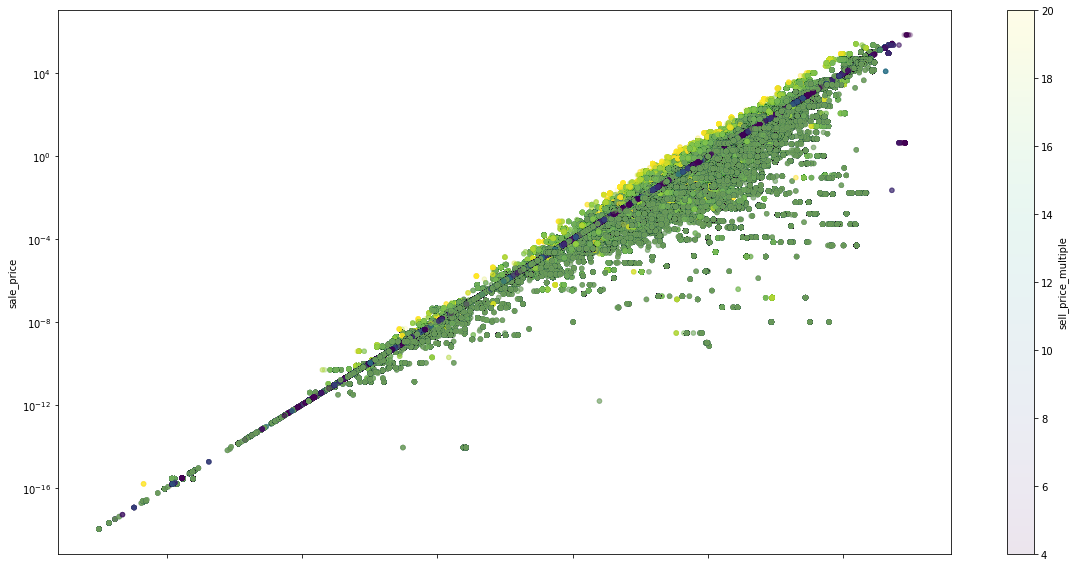

In [45]:
# updated_df[(updated_df['monthly_ROI']==np.Infinity) & (updated_df['duration']<5)].groupby(['duration','buy_volume_multiple'])['monthly_ROI'].count()
# filtered_df = updated_df[(updated_df['monthly_ROI']==np.Infinity)] #  & (updated_df['duration']<30)]
# filtered_df['monthly_ROI']=
updated_df.plot(x='buy_price', y='sale_price', c='sell_price_multiple', colormap='viridis', kind='scatter', figsize=(20,10), logx=True, logy=True, alpha=0.1)
# updated_df.plot(x='buy_date', y='duration', kind='scatter', figsize=(20,10))

In [157]:
buy_prices = main_df[main_df['buy_price'] > 0]

In [113]:
updated_df['buy_avg_volume'].describe(datetime_is_numeric=True)

count    1.393126e+07
mean     2.163045e+15
std               inf
min      1.111111e-04
25%      2.708415e+02
50%      3.283302e+03
75%      3.798824e+04
max      6.097563e+19
Name: buy_avg_volume, dtype: float64

In [45]:
updated_df.shape

(8457696, 15)

In [32]:
tadp = pd.read_pickle(Path(f'../downloaded_data/nomics/candles/ZT.pkl').resolve())
tadp = tadp.loc[(tadp['timestamp'] > '2021-05-01')] # & (tadp['timestamp'] < '2021-07-01')]
# tadp.plot(x='timestamp', y=['transparent_close', 'close', 'transparent_volume'], kind='line', figsize=(20,10), subplots=True)
print(tadp['close'].iloc[-1])

0.019128339


<AxesSubplot:xlabel='buy_date', ylabel='buy_avg_volume'>

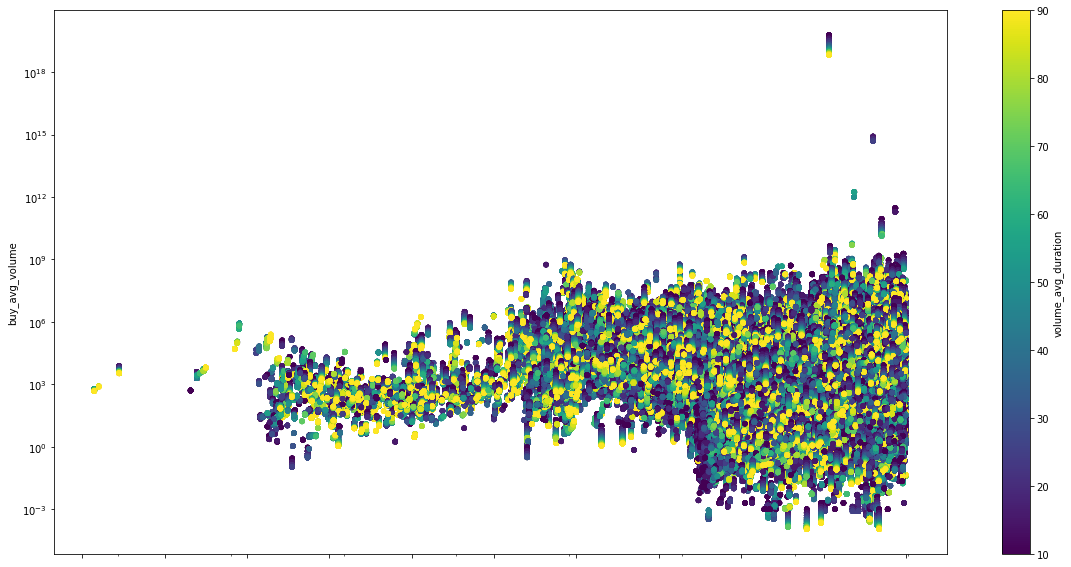

In [12]:

updated_df.plot(x='buy_date', y='buy_avg_volume', c='volume_avg_duration', cmap='viridis', kind='scatter', figsize=(20,10), subplots=False, logy=True)

<AxesSubplot:xlabel='buy_date', ylabel='buy_avg_volume'>

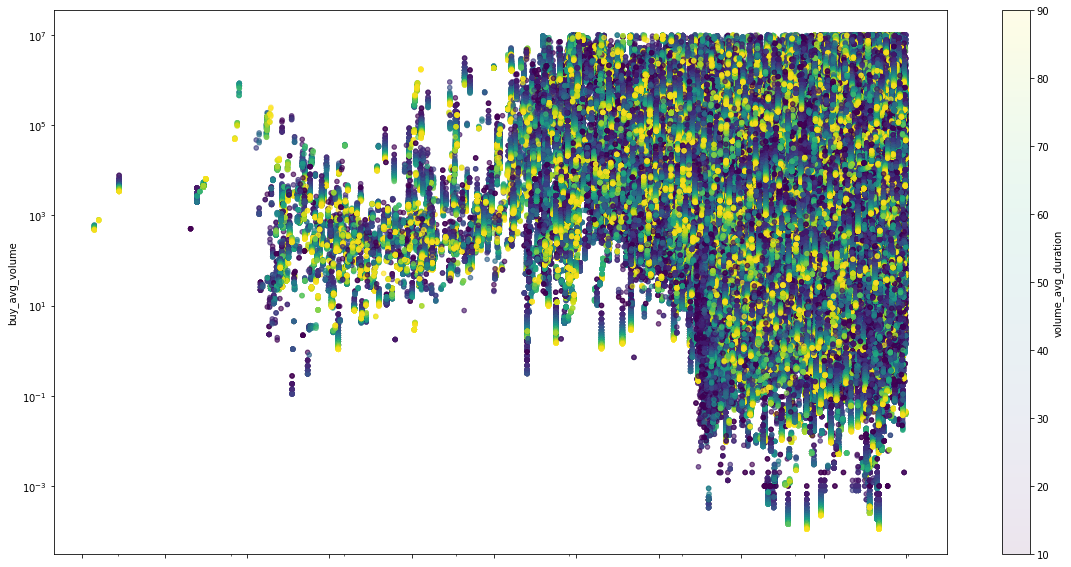

In [13]:
low_avg_volume = updated_df[updated_df['buy_avg_volume'] < 1000*1000*10]
# low_avg_volume.plot.hist(column=['buy_avg_volume'], bins=500, alpha=0.5, figsize=(20,10), legend=True, )
low_avg_volume.plot(x='buy_date', y='buy_avg_volume', c='volume_avg_duration', cmap='viridis', kind='scatter', alpha=0.1, figsize=(20,10), subplots=False, logy=True)

<AxesSubplot:xlabel='buy_avg_volume', ylabel='ROI'>

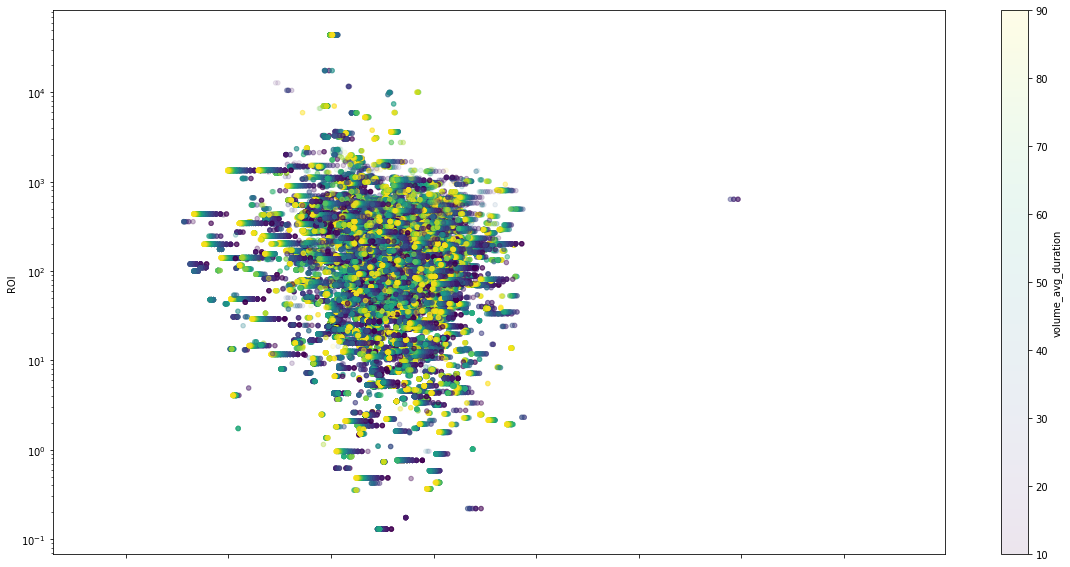

In [14]:
updated_df.plot(x='buy_avg_volume', y='ROI', c='volume_avg_duration', cmap='viridis', kind='scatter', alpha=.1, figsize=(20,10), subplots=False, logy=True, logx=True)

### Aggregate Analysis -WIP
<ol>
<li>Total Profit for all trades for a given set of parameters. New df with parameters and profits.</li>
<li>Avg Profit for all trades with a given set of parameters.-done</li>
<li>Number of trades executed for a given set of parameters.-done</li>
<li>A template to filter out trades open longer than X days.</li>
</ol>

In [7]:
def ROI_by_parameter(df: pd.DataFrame) -> pd.DataFrame:
    price_multiples = df['sell_price_multiple'].unique().tolist()
    volume_multiples = df['buy_volume_multiple'].unique().tolist()
    vol_avg_durations = df['volume_avg_duration'].unique().tolist()
    transparency = df['transparent'].unique().tolist()
    df = deepcopy(df)
    df['ROI'] = df['ROI'].astype('float64')
    # results = df.groupby(['sell_price_multiple', 'buy_volume_multiple', 'volume_avg_duration', 'transparent'])['ROI'].mean().reset_index()
    # print(results)
    new_df = pd.DataFrame(columns=['sell_price_multiple', 'buy_volume_multiple', 'volume_avg_duration', 'transparent', 'ROI_factor', 'avg_duration', 'avg_ROI', 'count'])
    for price_multiple in price_multiples:
        for volume_multiple in volume_multiples:
            for vol_avg_duration in vol_avg_durations:
                for transparent in transparency:
                    temp_df = df[(df['sell_price_multiple']==price_multiple) & (df['buy_volume_multiple']==volume_multiple) &
                        (df['volume_avg_duration']==vol_avg_duration) & (df['transparent']==transparent)]
                    # pp(temp_df)
                    new_df = new_df.append({'sell_price_multiple': price_multiple,
                                            'buy_volume_multiple': volume_multiple,
                                            'volume_avg_duration': vol_avg_duration,
                                            'transparent': transparent,
                                            'ROI_factor': temp_df['ROI'].mean()/100,
                                            'avg_duration': temp_df['duration'].mean(),
                                            'count': len(temp_df)}, ignore_index=True)

    return new_df

<AxesSubplot:xlabel='Volume Avg Duration', ylabel='ROI_factor'>

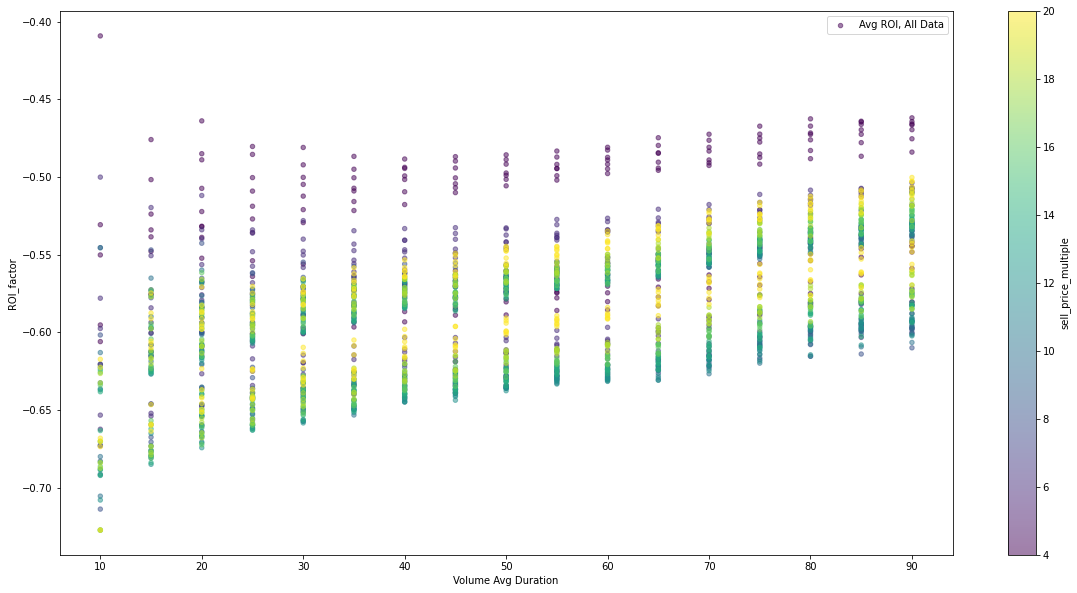

In [112]:
result = ROI_by_parameter(updated_df)
result.plot(x='volume_avg_duration', y='ROI_factor', c='sell_price_multiple', cmap='viridis', kind='scatter', alpha=.5, figsize=(20,10), subplots=False, logy=False, sharex=False, xlabel='Volume Avg Duration',  label='Avg ROI, All Data')

### Result 1
Having used the entire data set, with no time expiration date, no combination of results is profitable.

<AxesSubplot:xlabel='Volume Avg Duration', ylabel='ROI_factor'>

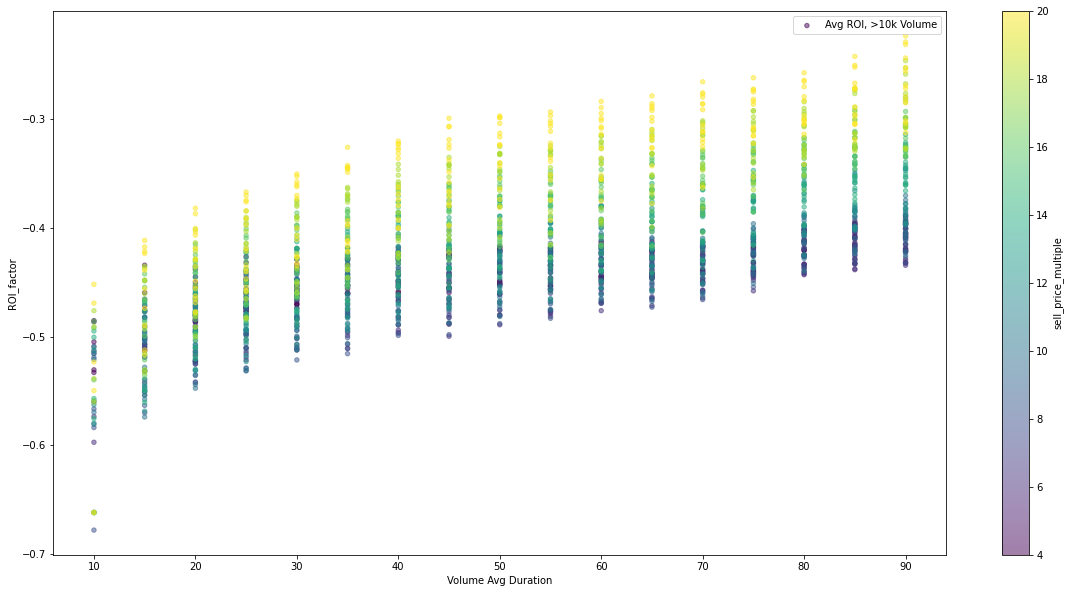

In [114]:
filtered_df = deepcopy(updated_df[(updated_df['buy_avg_volume']>=10000)]).reset_index(drop=True)
result = ROI_by_parameter(filtered_df)
result.plot(x='volume_avg_duration', y='ROI_factor', c='sell_price_multiple', cmap='viridis', kind='scatter', alpha=.5, figsize=(20,10), subplots=False, logy=False, sharex=False, xlabel='Volume Avg Duration',  label='Avg ROI, >10k Volume')

### Result 2
Filtering out to only include currencies with >$10k volume avg before executing, with no time expiration date, no combination of results is profitable.

<AxesSubplot:xlabel='Volume Avg Duration', ylabel='ROI_factor'>

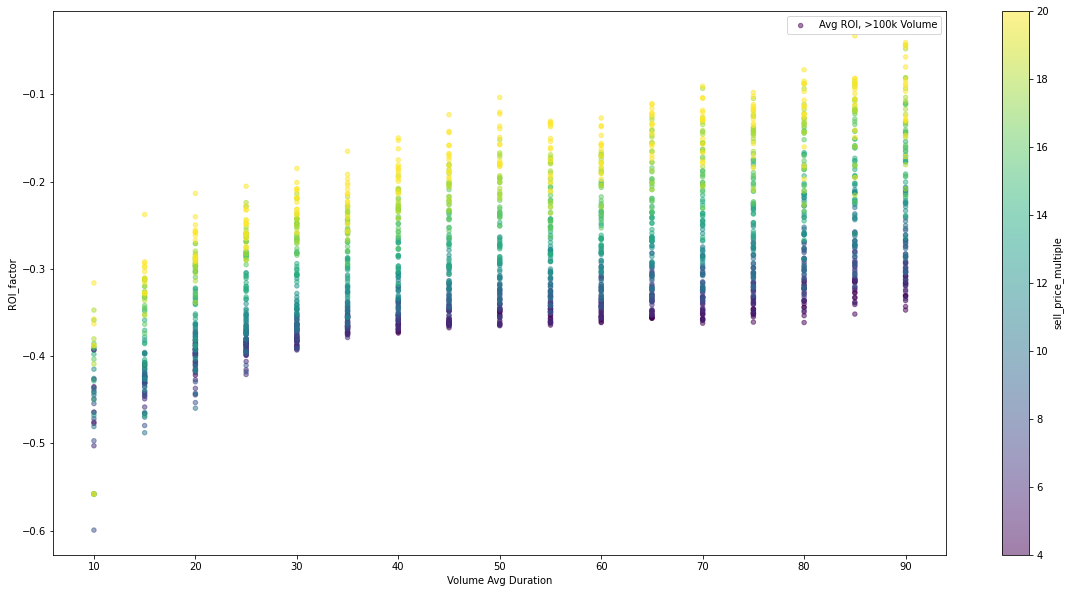

In [115]:
filtered_df = deepcopy(updated_df[(updated_df['buy_avg_volume']>=100000)]).reset_index(drop=True)
result = ROI_by_parameter(filtered_df)
result.plot(x='volume_avg_duration', y='ROI_factor', c='sell_price_multiple', cmap='viridis', kind='scatter', alpha=.5, figsize=(20,10), subplots=False, logy=False, sharex=False, xlabel='Volume Avg Duration',  label='Avg ROI, >100k Volume')

### Result 3
Filtering out to only include currencies with >$100k volume avg before executing, with no time expiration date, no combination of results is profitable.

In [15]:
# now try with a 180 day max duration
for max_duration in [15]:         # 30, 45, 60, 90, 180
    new_df = apply_functions(main_df, duration_max=max_duration)
    new_df.to_pickle(Path(f'../bt_data_runs/cleaned_archive_max_{max_duration}d.pkl').resolve())
    volume_max = [0, 10_000, 100_000, 250_000, 500_000, 1_000_000]
    print(f'Max Duration: {max_duration}')
    # for volume in volume_max:
    #     temp_df = new_df[(new_df['buy_avg_volume']>=volume)]
    #     result = ROI_by_parameter(temp_df)
    #     result.plot(x='volume_avg_duration', y='ROI_factor', c='sell_price_multiple', cmap='viridis', kind='scatter',
    #     alpha=.5, figsize=(20,10), subplots=True, logy=False, sharex=False, xlabel='Volume Avg Duration', label=f'Avg ROI, Volume > {volume}, <{max_duration}d Duration')

Max Duration: 15


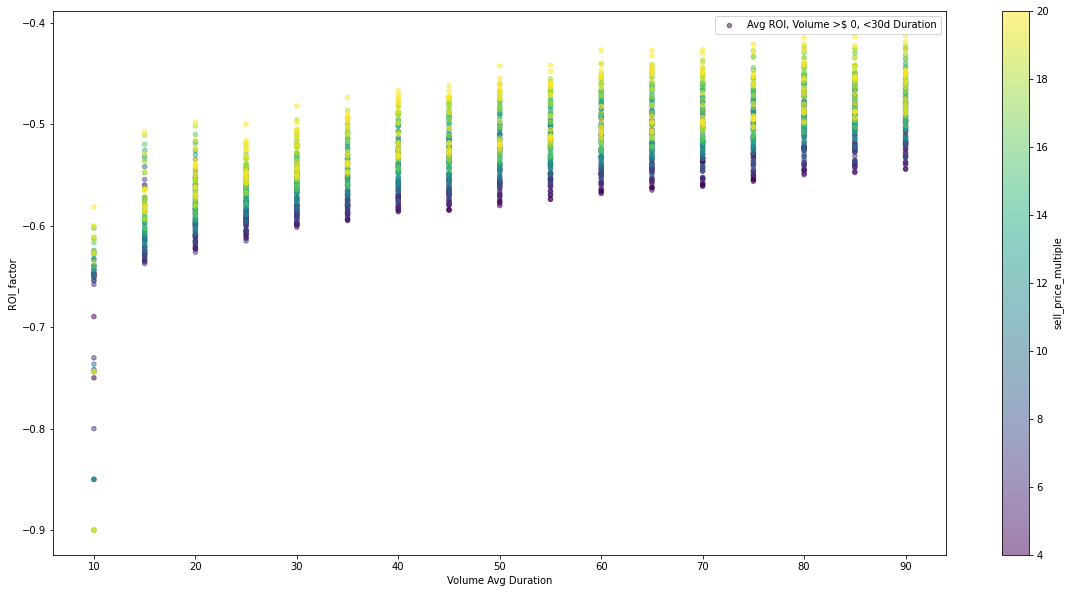

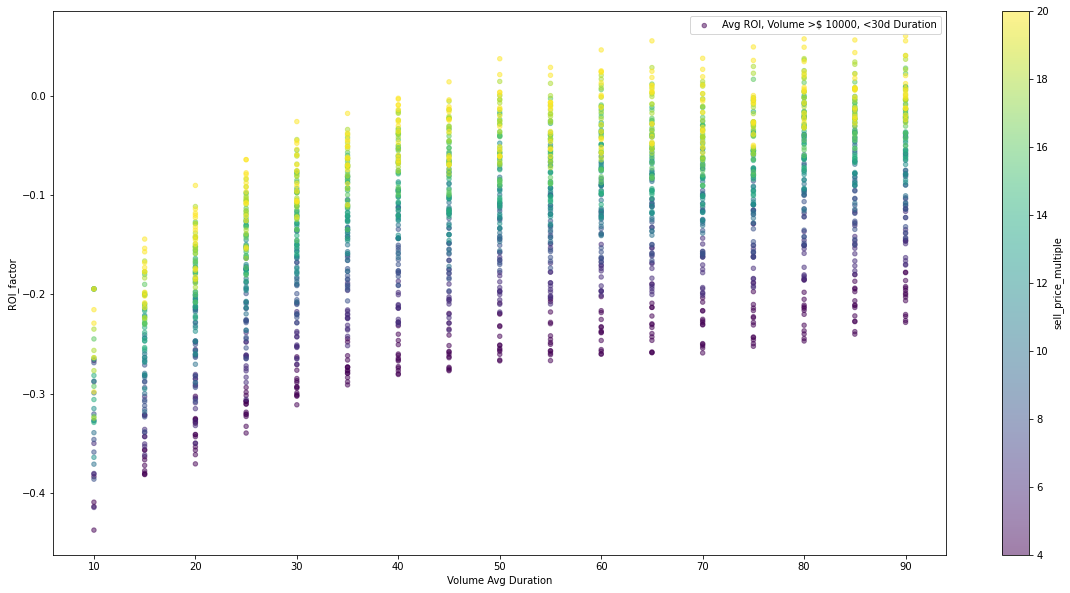

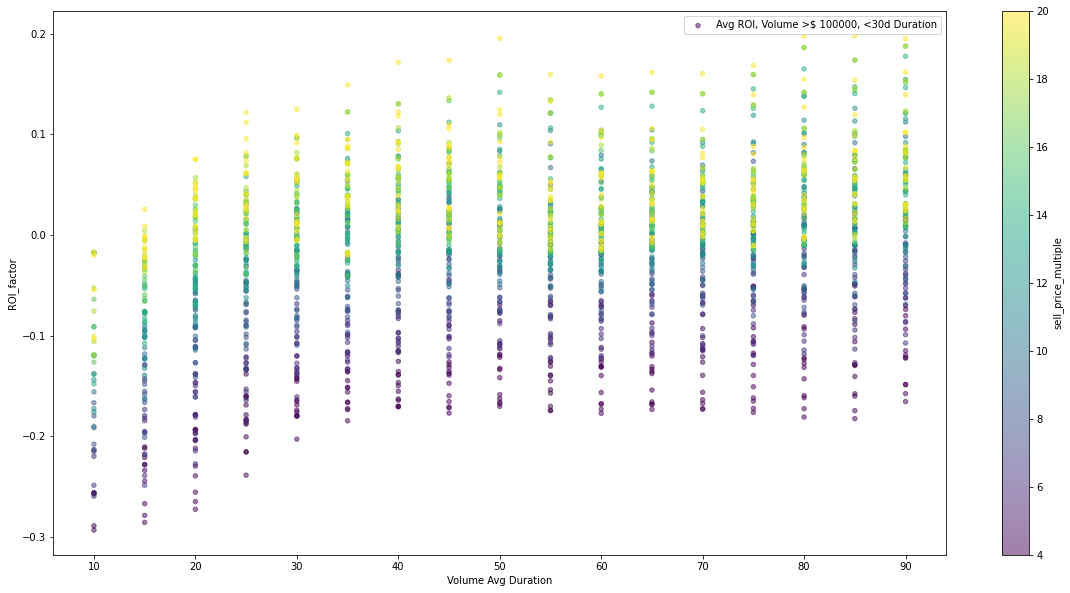

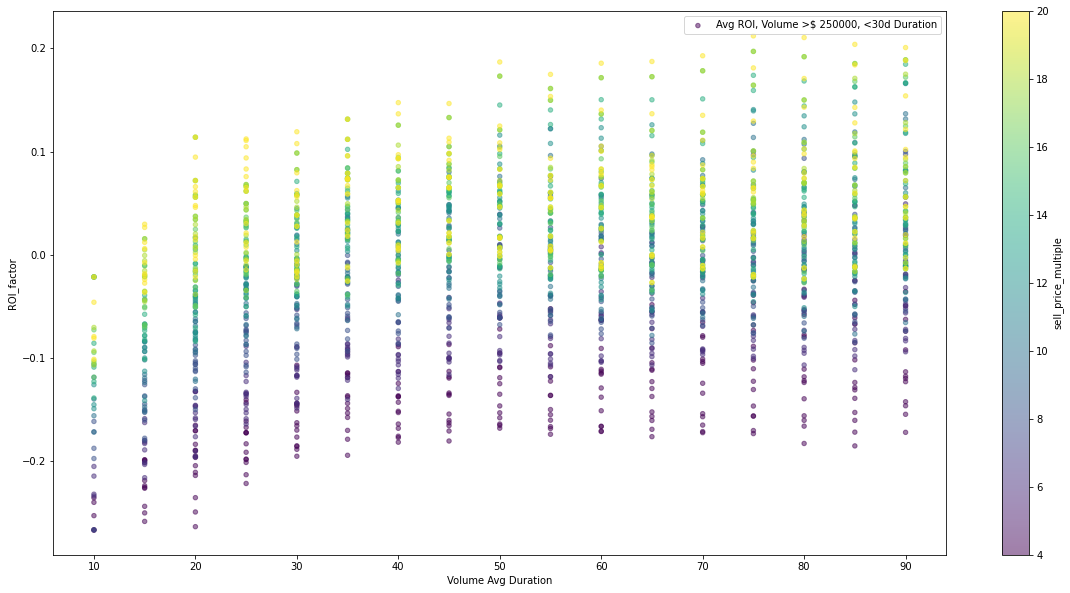

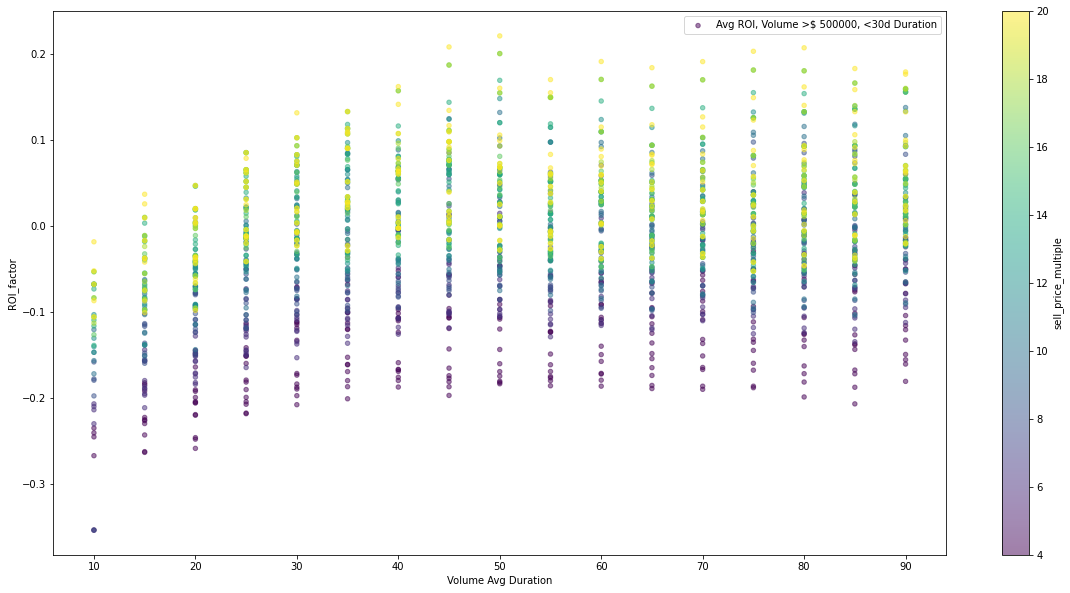

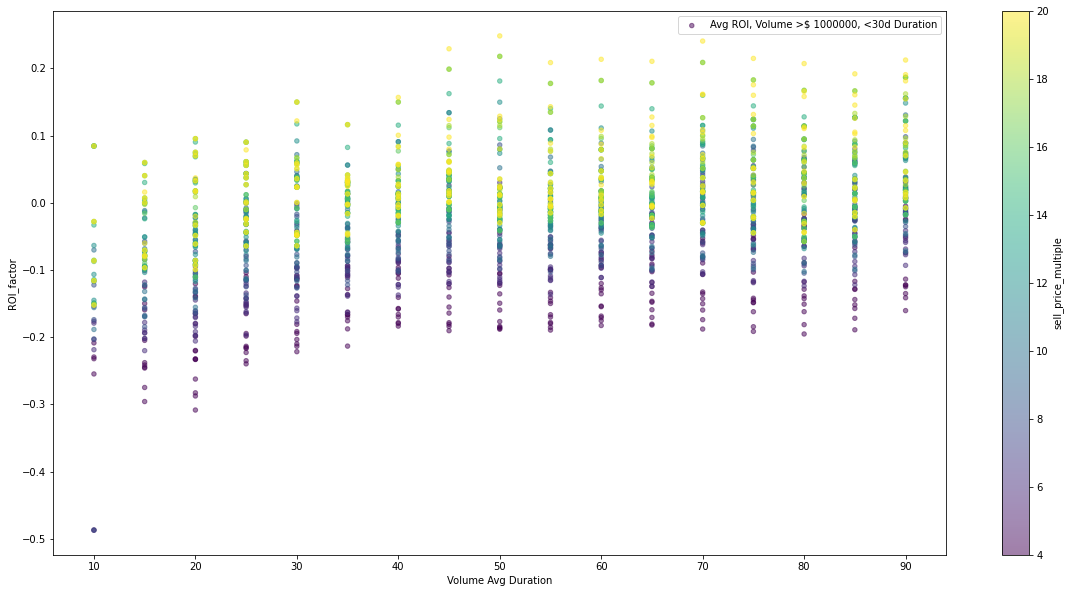

In [10]:
def show_plots(max_duration: int,/,) -> None:
    df_path = Path(f'../bt_data_runs/cleaned_archive_max_{max_duration}d.pkl').resolve()
    assert df_path.exists()
    new_df = pd.read_pickle(df_path)
    volume_max = [0, 10_000, 100_000, 250_000, 500_000, 1_000_000]
    for volume in volume_max:
            temp_df = new_df[(new_df['buy_avg_volume']>=volume)]
            result = ROI_by_parameter(temp_df)
            result.plot(x='volume_avg_duration', y='ROI_factor', c='sell_price_multiple', cmap='viridis', kind='scatter',
            alpha=.5, figsize=(20,10), subplots=True, logy=False, sharex=False, xlabel='Volume Avg Duration', 
            label=f'Avg ROI, Volume >$ {volume}, <{max_duration}d Duration')

show_plots(30)

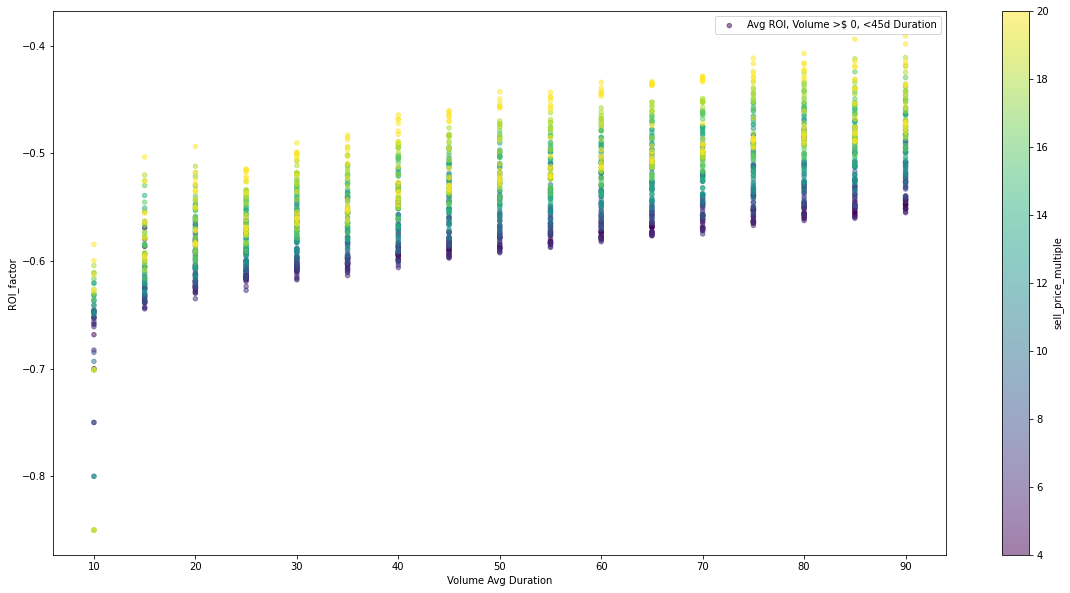

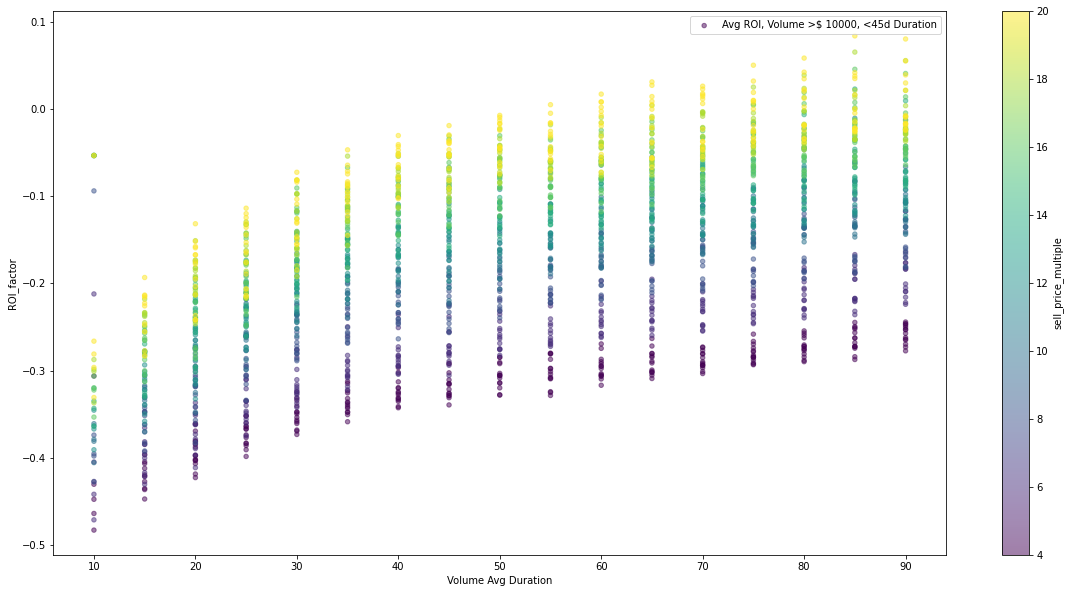

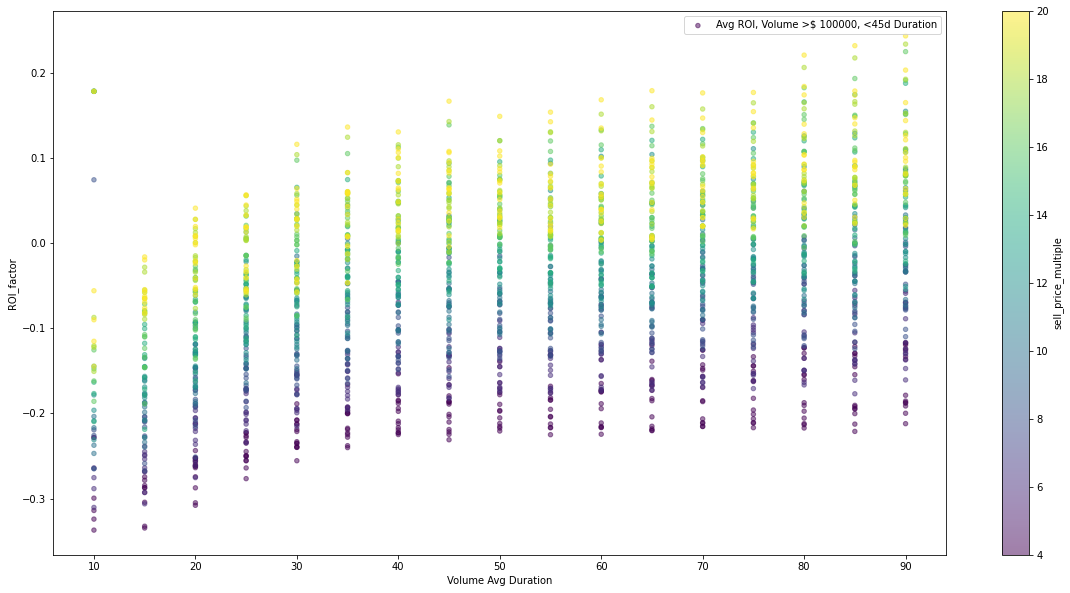

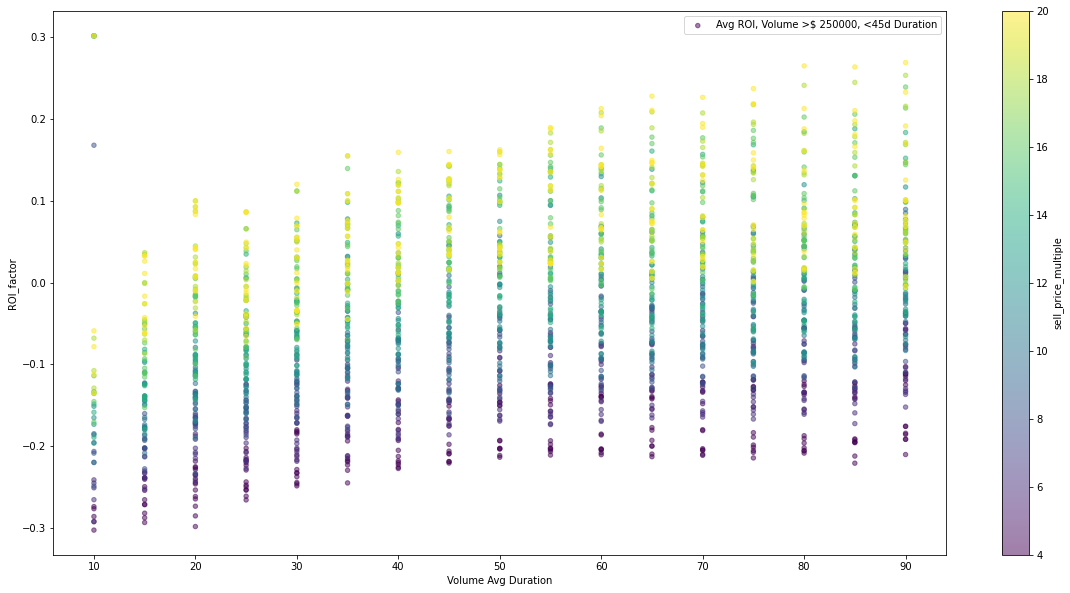

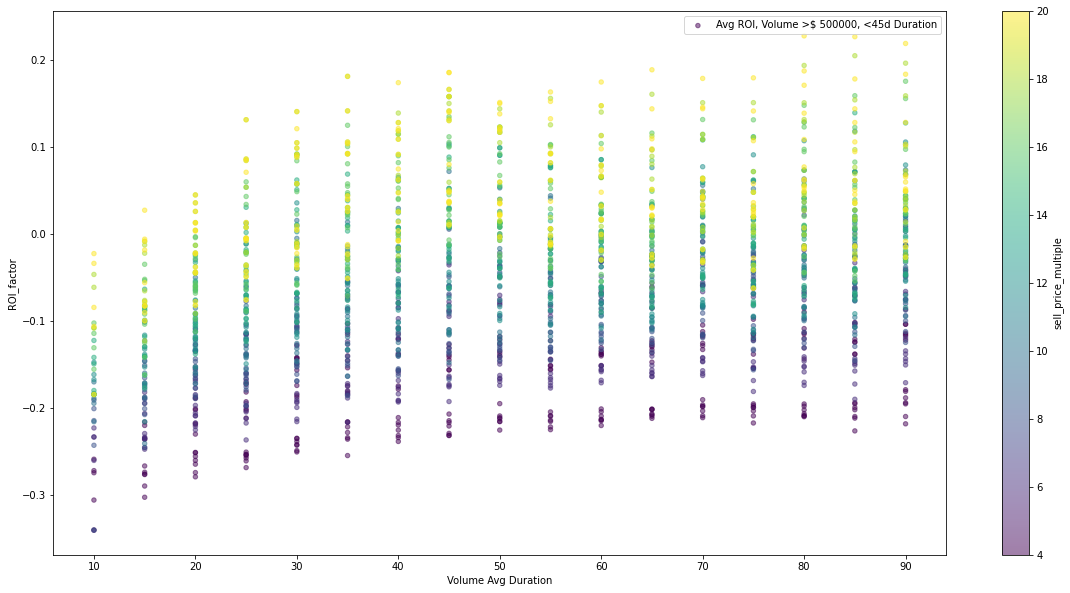

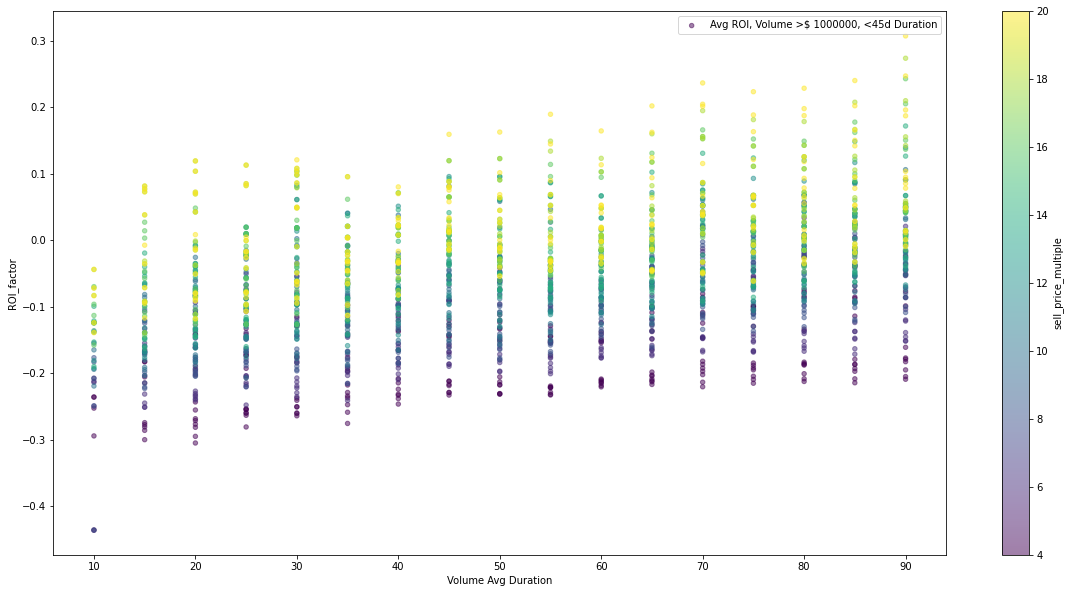

In [11]:
show_plots(45)

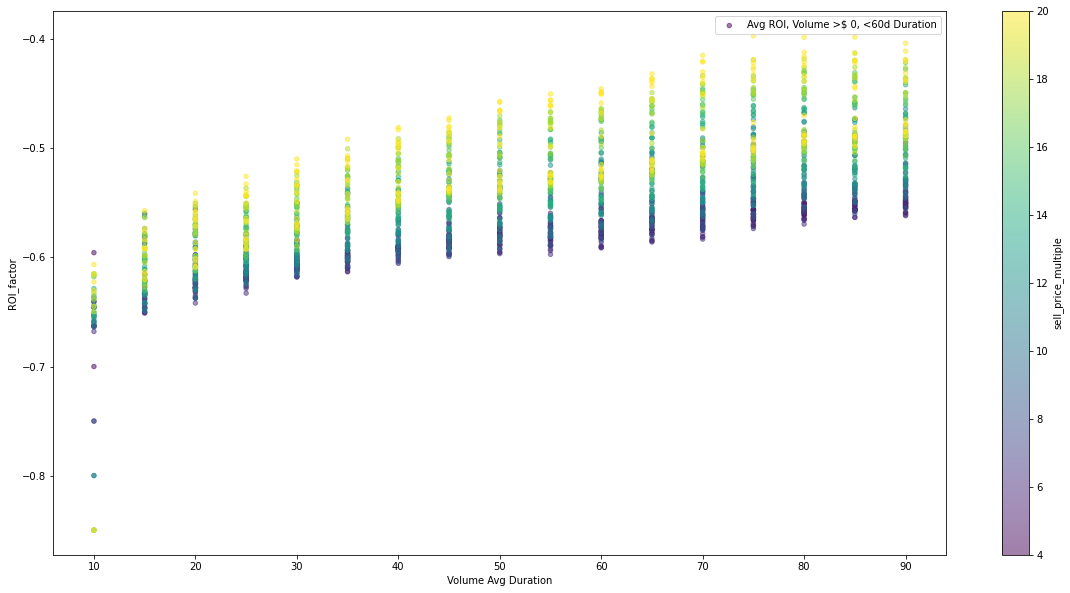

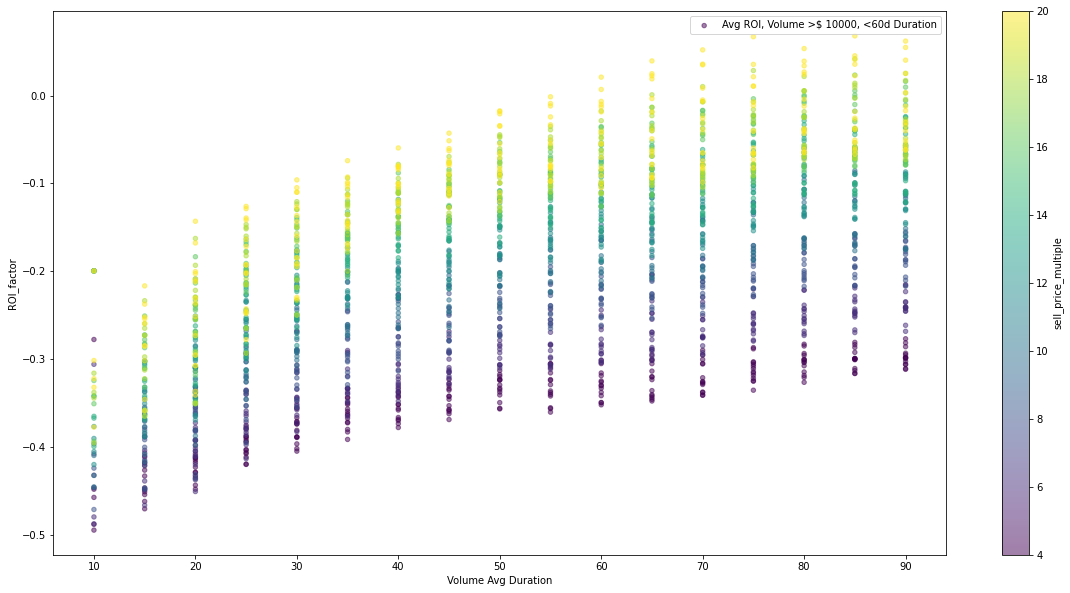

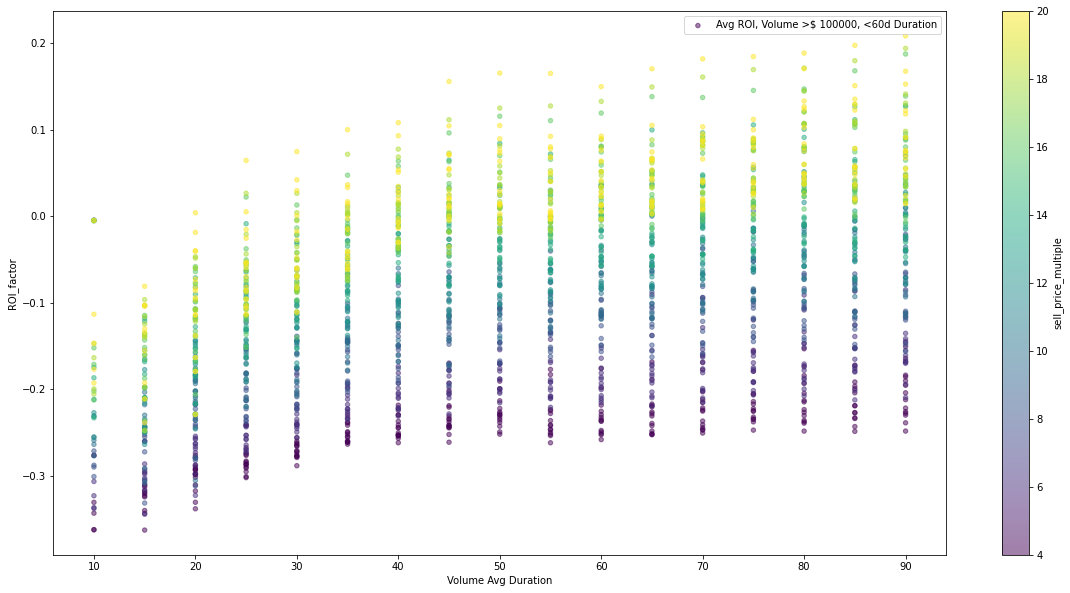

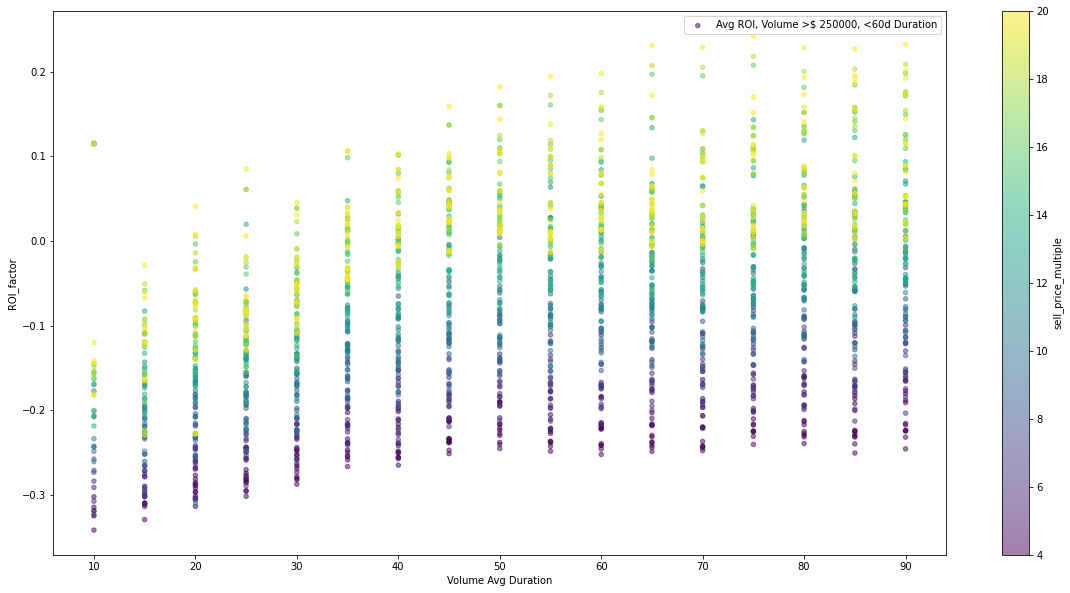

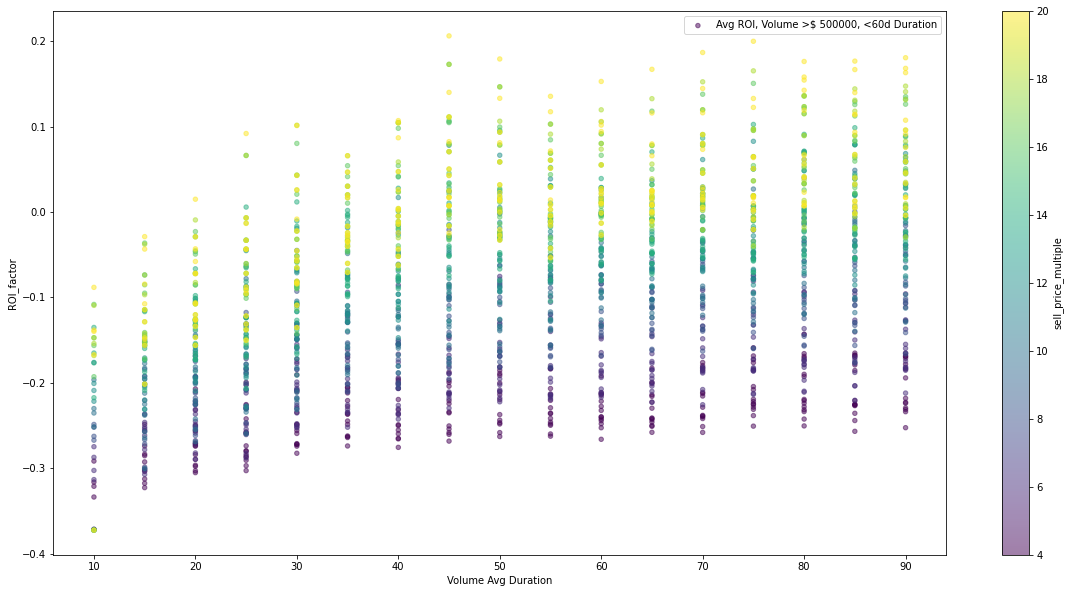

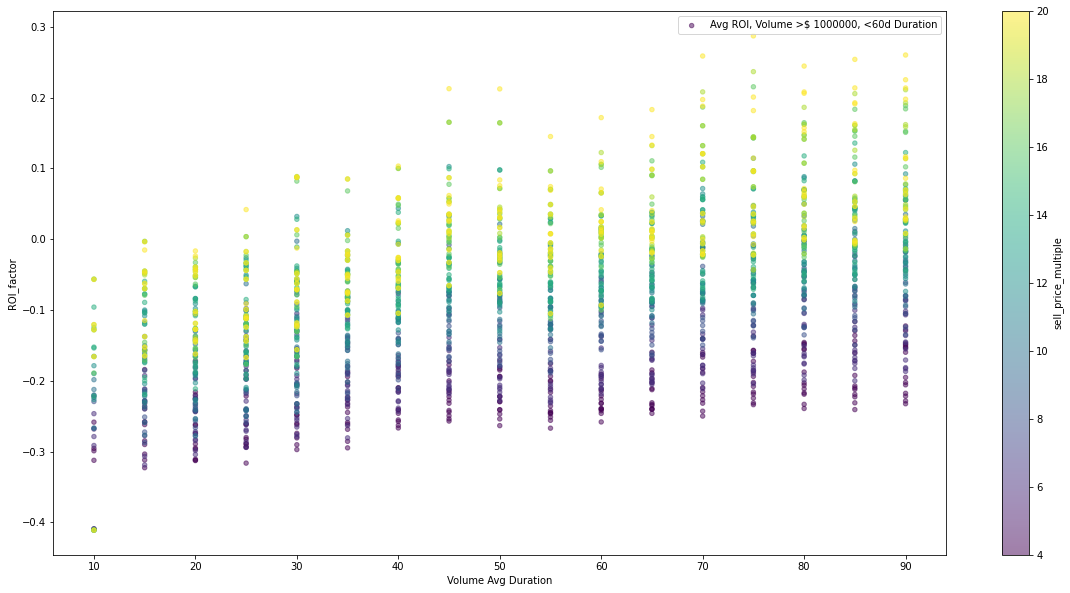

In [12]:
show_plots(60)

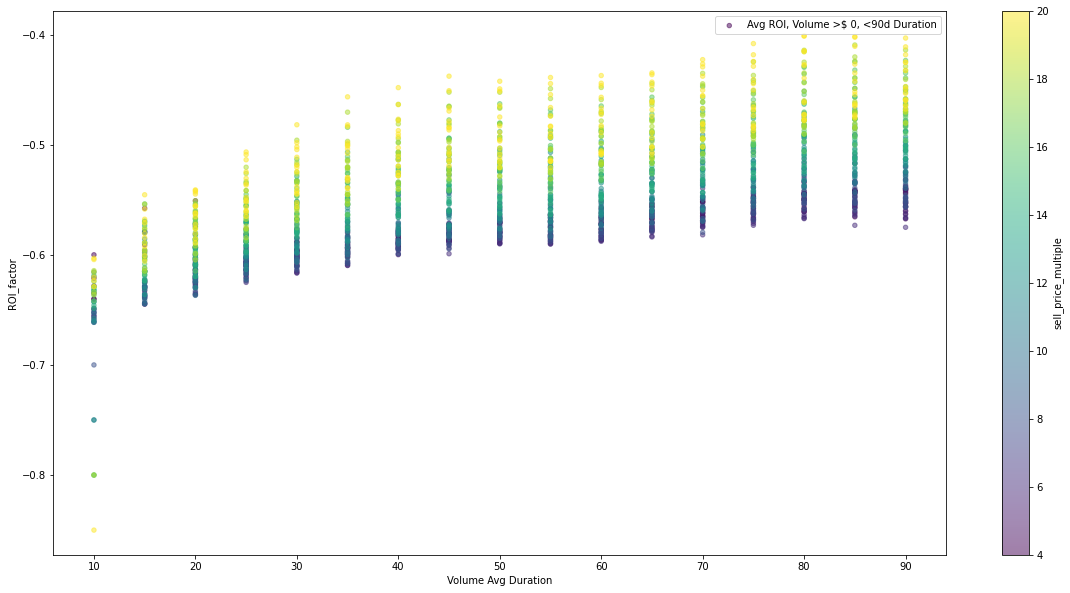

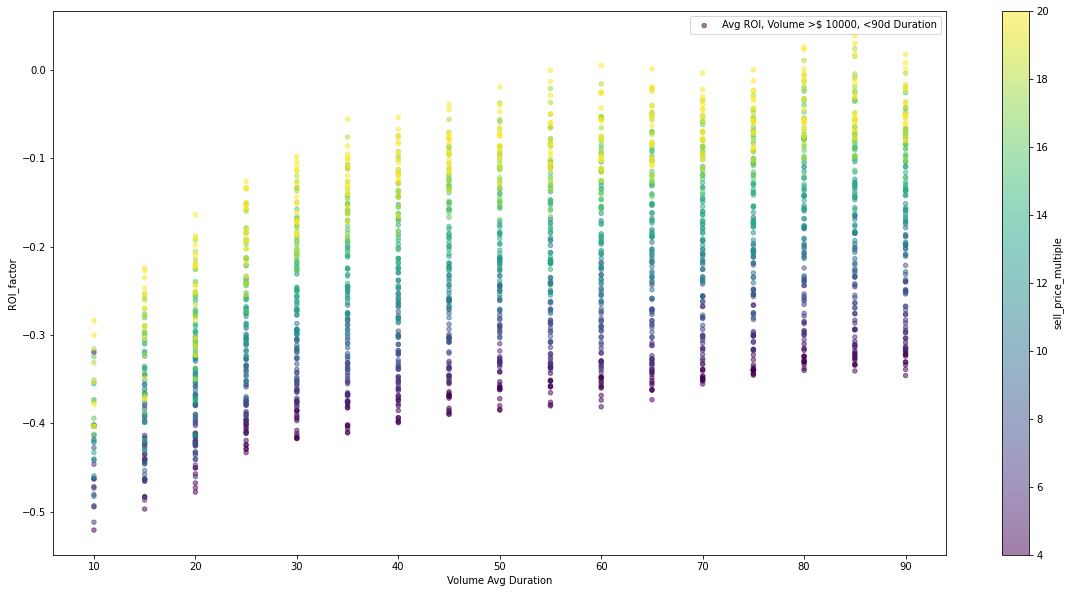

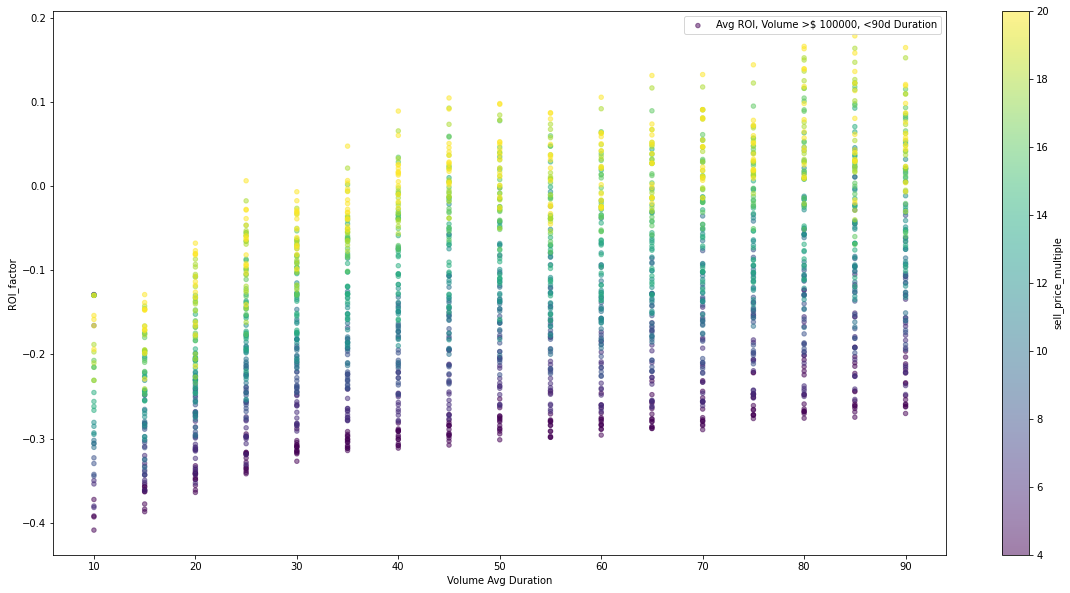

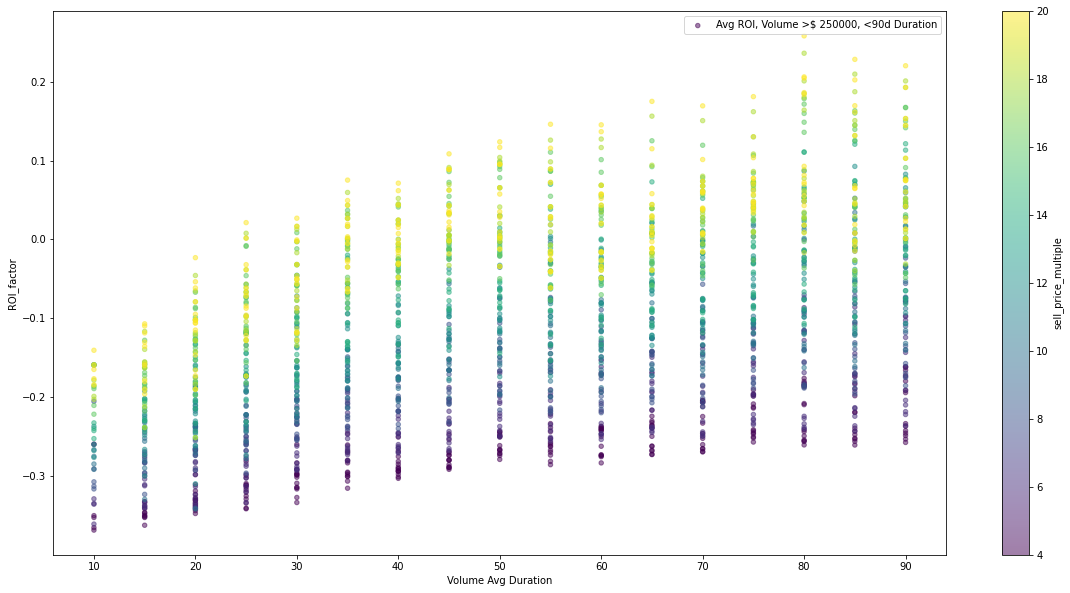

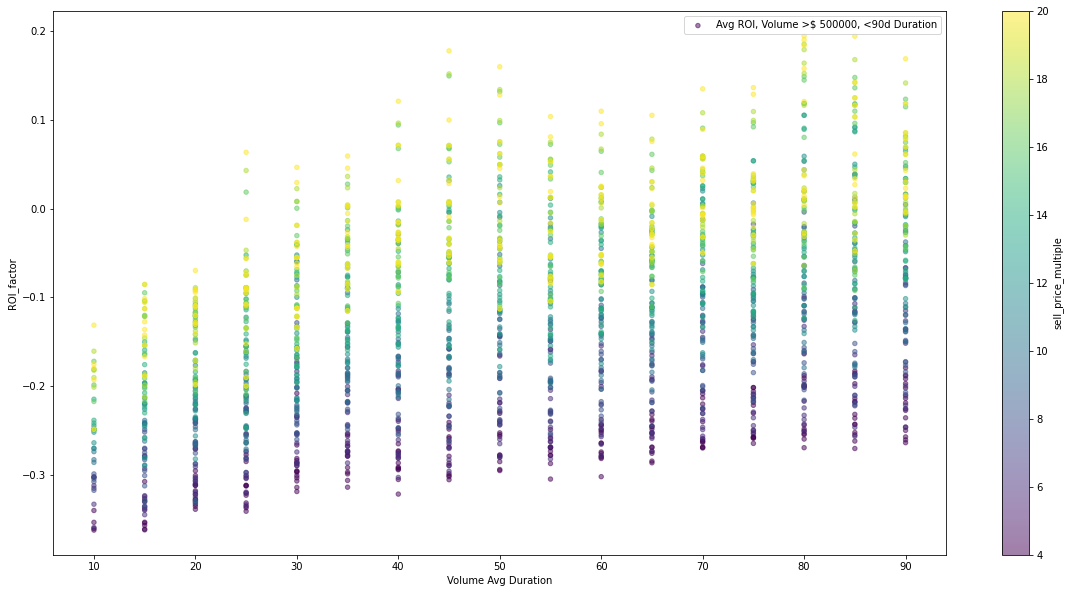

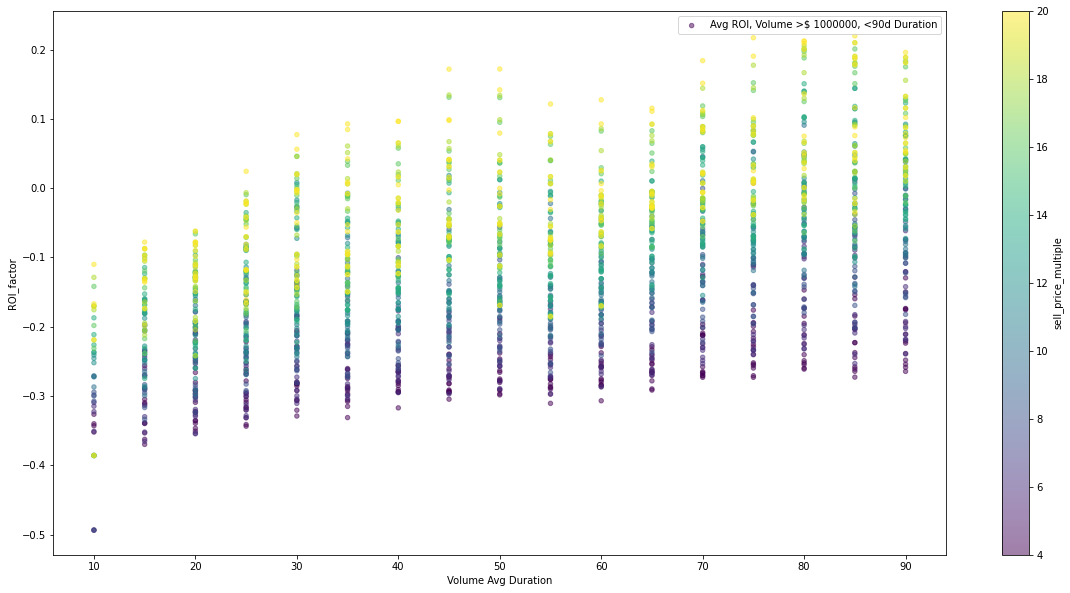

In [13]:
show_plots(90)

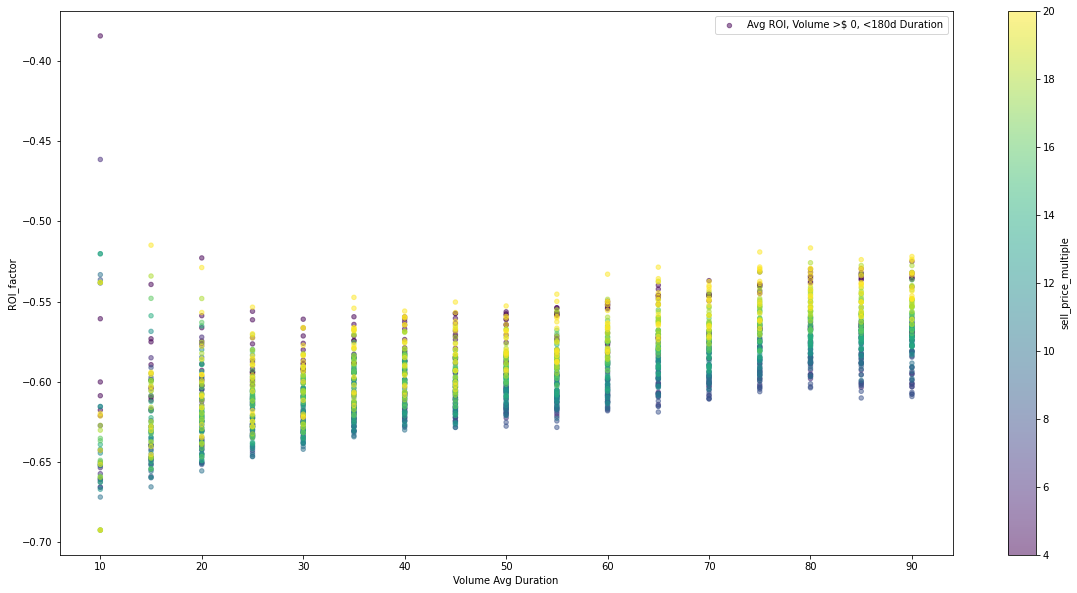

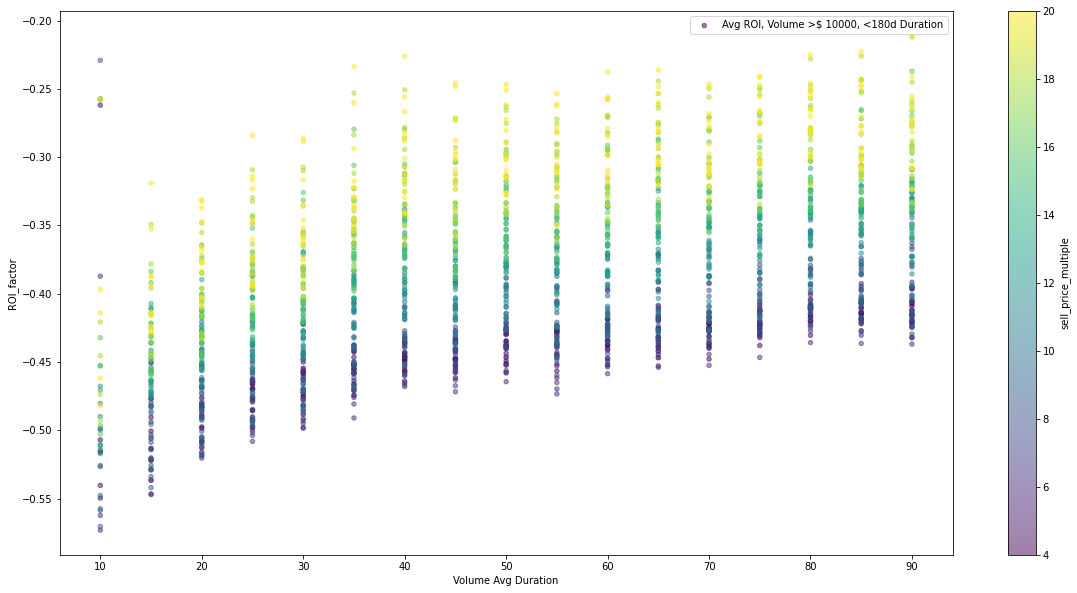

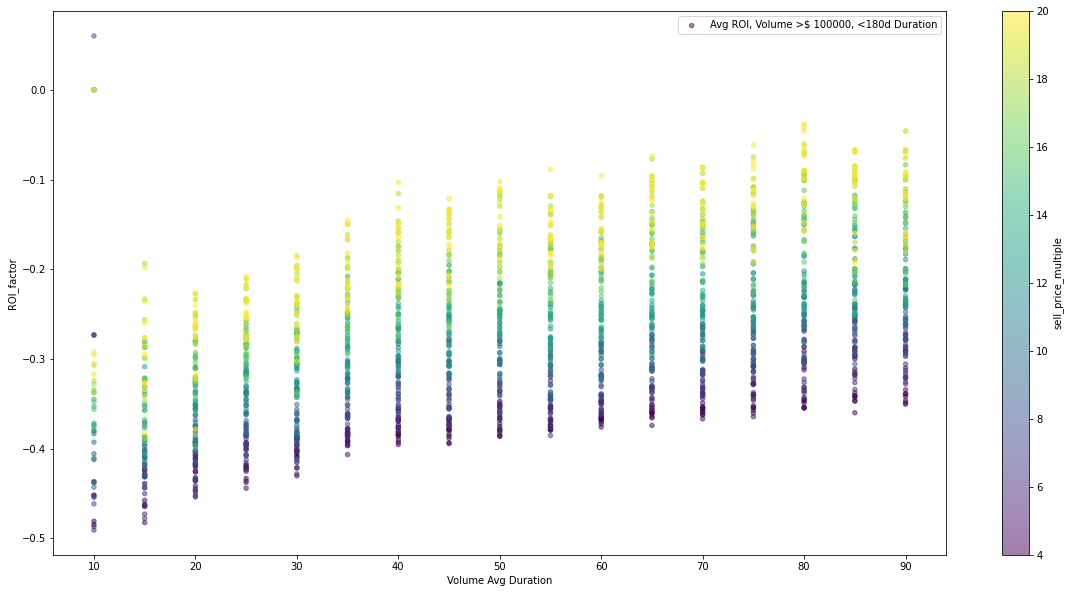

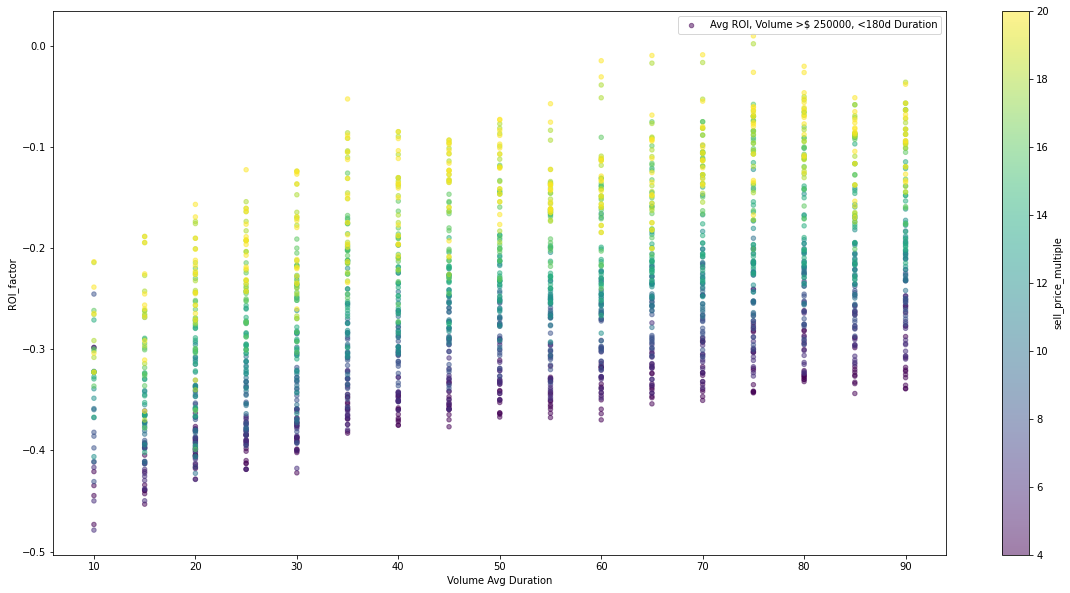

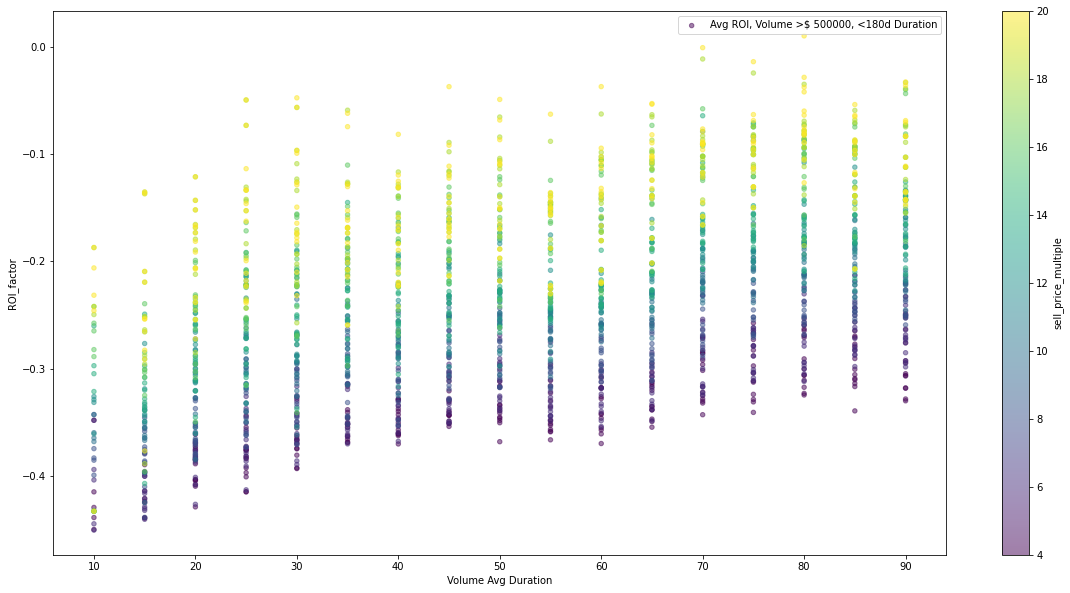

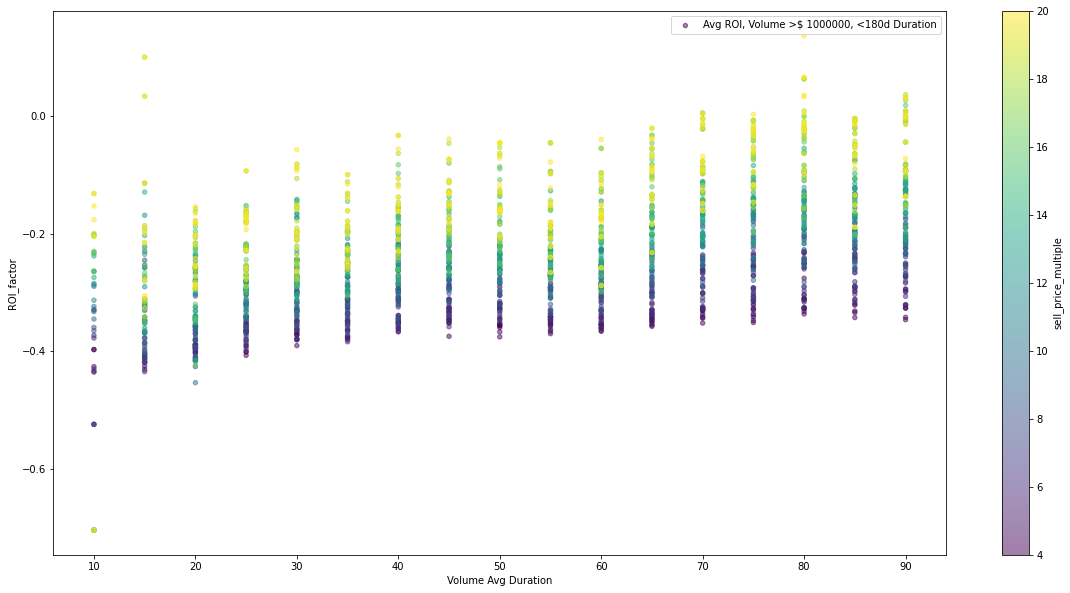

In [14]:
show_plots(180)


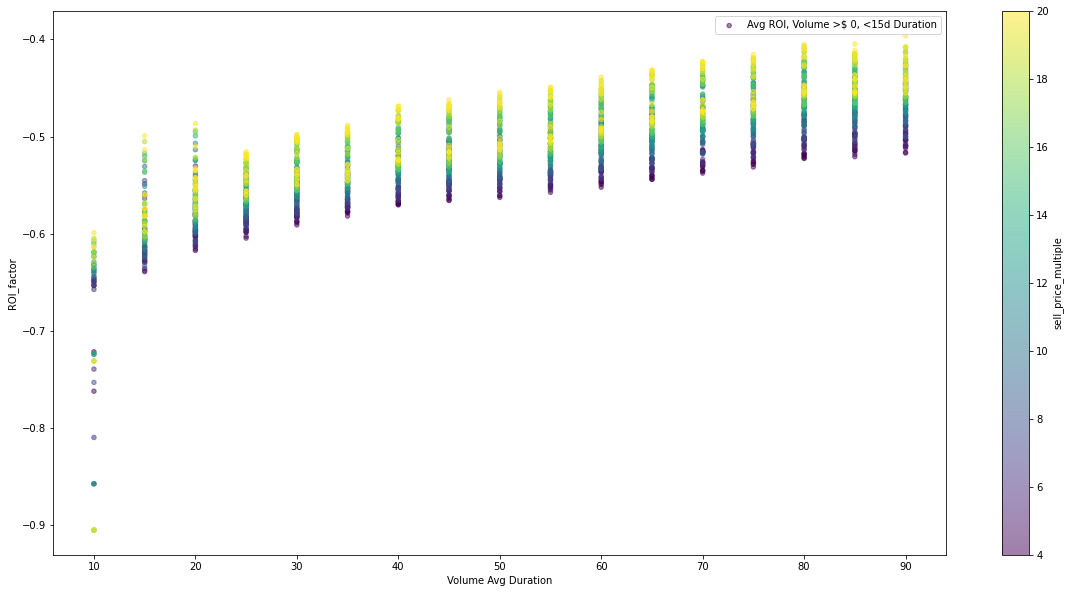

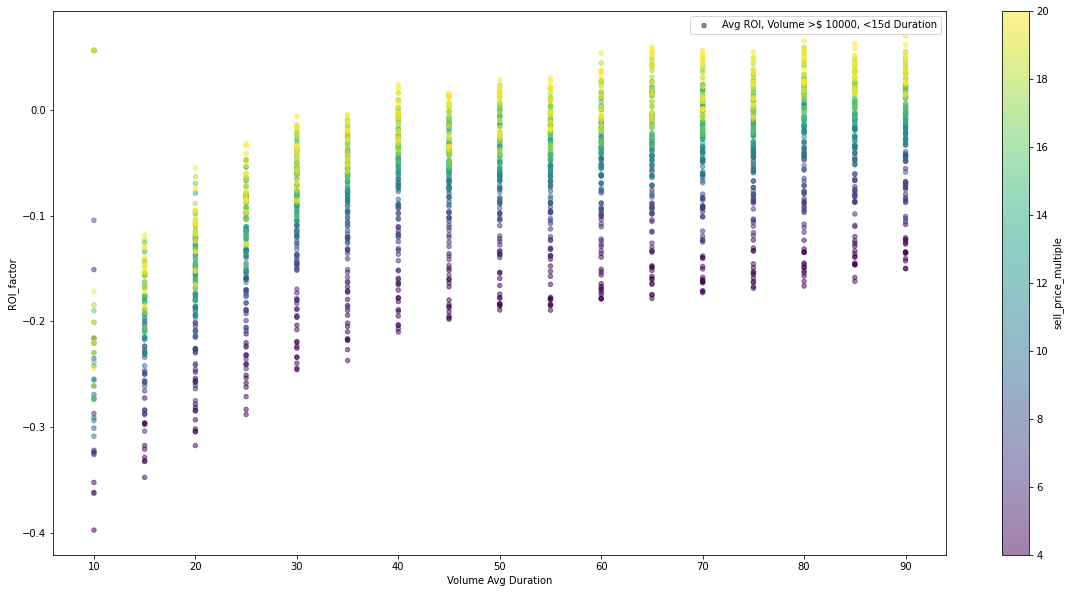

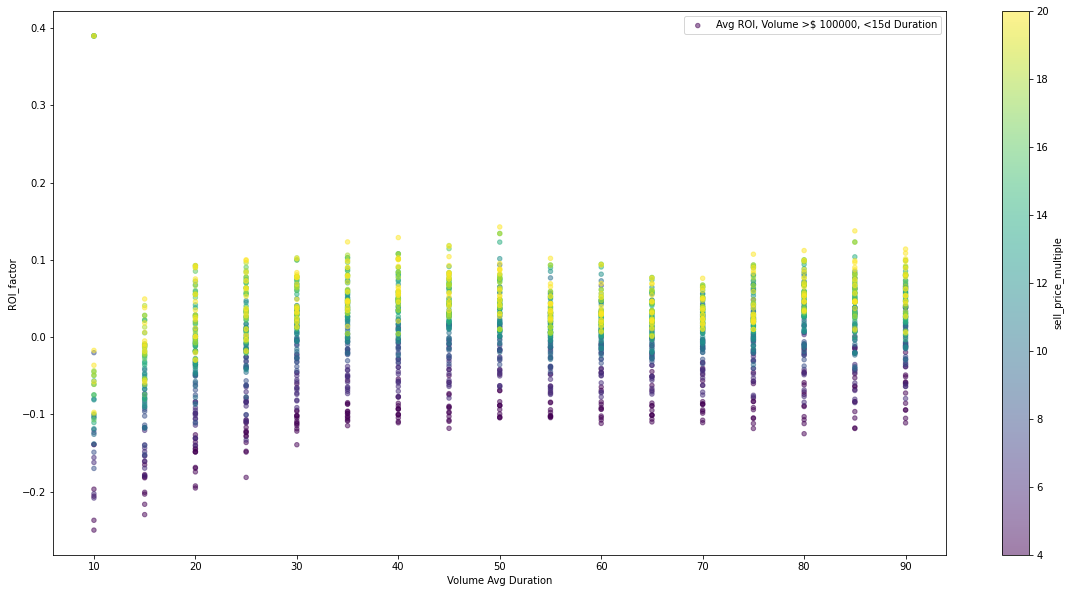

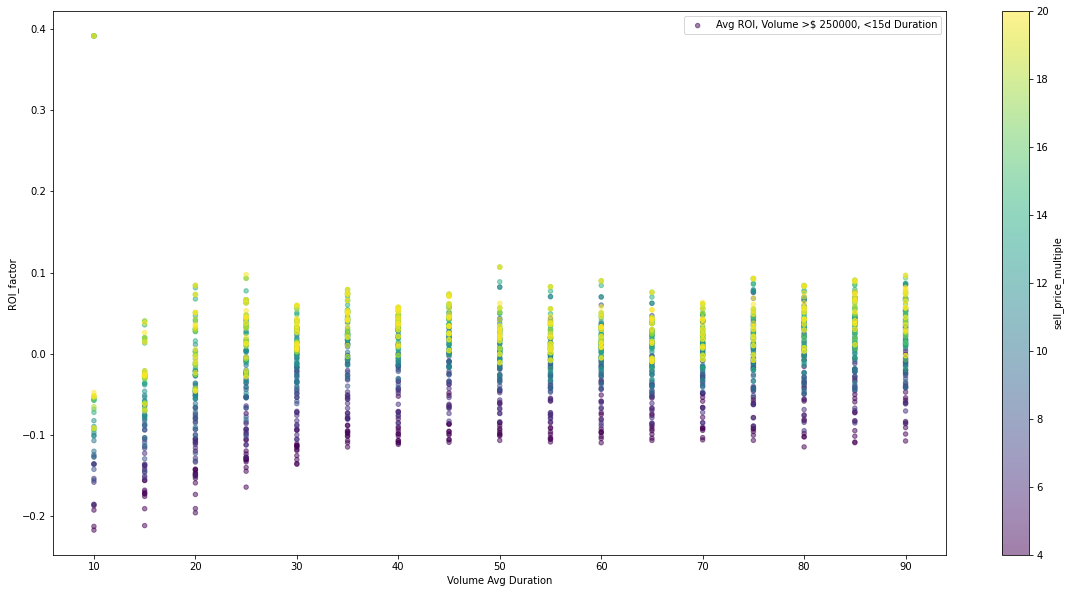

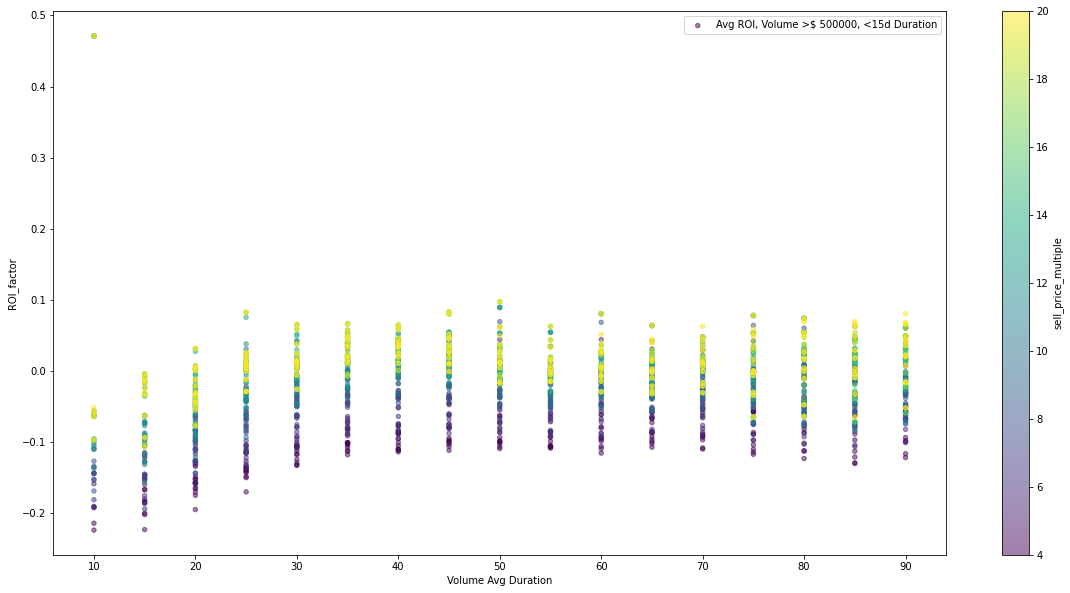

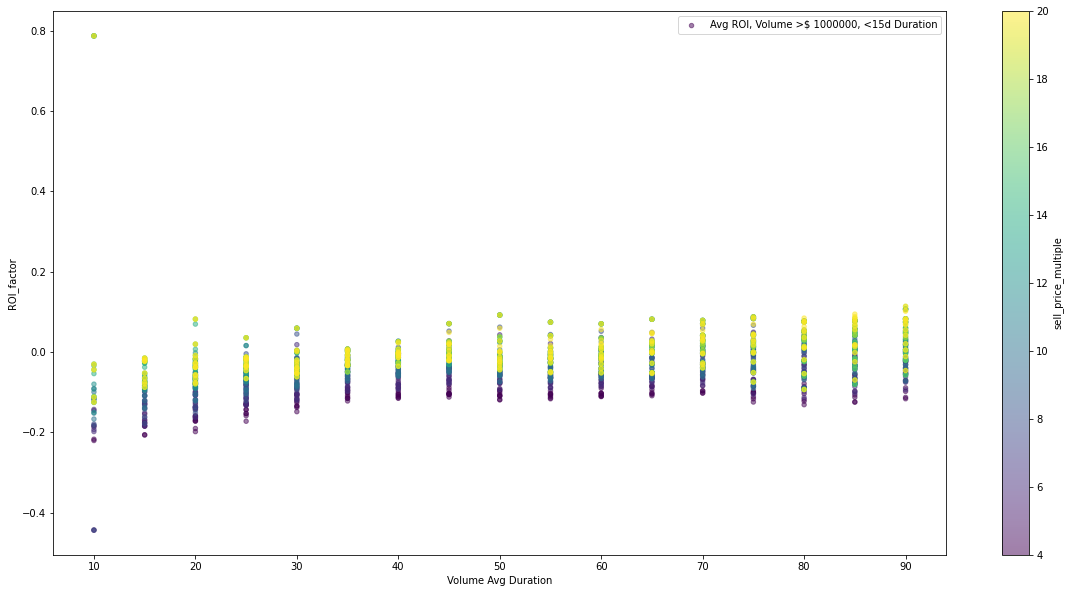

In [16]:
show_plots(15)

In [15]:
df_path = Path(f'../bt_data_runs/cleaned_archive_max_{30}d.pkl').resolve()
# df = pd.read_pickle(df_path)
# df.columns
df[df['buy_avg_volume'] > 500_000]['currency_id'].value_counts()
# 2841 total currencies with >0.5MM avg volume before trading execution
# 2099 total currencies with >1MM avg volume before trading execution
# df.plot(x='volume_avg_duration', y='buy_avg_volume', c='sell_price_multiple', cmap='viridis', kind='scatter', figsize=(20,10), subplots=False, logy=False, sharex=False,  label='')

DOT5S         2016
BCH5S         2016
DFL4          2016
DINO3         2016
AAVE          2016
              ... 
GAIA4            9
GAME3            9
RVF              9
MASQ             9
BDIGGBEP20       6
Name: currency_id, Length: 2841, dtype: int64